In [9]:
import numpy as np
import torch
import torchaudio.transforms as transforms
import torchaudio
from librosa import filters
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

In [10]:
DEFAULT_HOP_WIDTH = 128
DEFAULT_SAMPLE_RATE = 16000
SAMPLE_RATE = DEFAULT_SAMPLE_RATE
DEFAULT_NUM_MEL_BINS = 512
DEFAULT_INPUT_LENGTH = 256

# Constants for spectrogram computation
FFT_SIZE = 2048
MEL_LO_HZ = 20.0

In [11]:
class SpectogramConfig:
    hop_width: int = DEFAULT_HOP_WIDTH
    sample_rate: int = DEFAULT_SAMPLE_RATE
    num_mel_bins: int = DEFAULT_NUM_MEL_BINS
    fft_size: int = FFT_SIZE
    mel_lo_hz: float = MEL_LO_HZ
    input_length: int = DEFAULT_INPUT_LENGTH

    @property
    def frames_per_second(self):
        return self.sample_rate / self.hop_width
    
    @property
    def abbrev_str(self):
        s = ''
        if self.sample_rate != DEFAULT_SAMPLE_RATE:
            s += 'sr%d' % self.sample_rate
        if self.hop_width != DEFAULT_HOP_WIDTH:
            s += 'hw%d' % self.hop_width
        if self.num_mel_bins != DEFAULT_NUM_MEL_BINS:
            s += 'mb%d' % self.num_mel_bins
        return s

def split_audio(samples, spectrogram_config):
    """Split audio into frames using PyTorch and NumPy."""
    frame_length = spectrogram_config.hop_width
    frame_step = spectrogram_config.hop_width
    pad_end = True
    
    if pad_end:
        pad_value = (len(samples) + frame_step - 1) // frame_step * frame_step - len(samples)
        samples = np.pad(samples, (0, pad_value), mode='constant')
    
    num_frames = (len(samples) - frame_length) // frame_step + 1
    
    frames = np.lib.stride_tricks.as_strided(
        samples,
        shape=(num_frames, frame_length),
        strides=(samples.strides[0] * frame_step, samples.strides[0])
    )
    
    return torch.tensor(frames)


def compute_spectrogram(samples, spectrogram_config):
    """
    Compute a mel spectrogram from a given audio sample.

    Args:
        samples: A NumPy array of audio samples.
        spectrogram_config: SpectrogramConfig object containing parameters.

    Returns:
        A PyTorch tensor representing the mel spectrogram.
    """
    sample_rate = spectrogram_config.sample_rate
    frame_size = spectrogram_config.hop_width
    n_mels = spectrogram_config.num_mel_bins
    fft_size = spectrogram_config.fft_size

    # Convert samples to a PyTorch tensor
    samples_tensor = torch.from_numpy(samples).float()

    # Compute the mel spectrogram using torchaudio
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=fft_size,
        hop_length=frame_size,
        win_length=fft_size,
        n_mels=n_mels
    )(samples_tensor)

    # Convert to log scale (dB)
    log_mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

    # Ensure resulting spectrogram has the desired shape
    if log_mel_spectrogram.size(1) > spectrogram_config.input_length:
        log_mel_spectrogram = log_mel_spectrogram[:, :spectrogram_config.input_length]
    
    return log_mel_spectrogram.T

def plot_spectrogram(spectrogram, ax, sample_rate, title=None):
    """Plot the spectrogram."""
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', interpolation='none')
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Frequency (bins)')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax)
    # plt.show()

In [12]:
def split_tokens_to_inputs_length(ds, sequence_length, additional_feature_keys=None):
    tokens = ds['inputs']
    input_times = ds['input_times']
    max_tokens = sequence_length['inputs']
    num_tokens = tokens.shape[0]    # number of frames
    frame_size = tokens.shape[1]

    num_segments = (num_tokens + max_tokens - 1) // max_tokens
    padding = num_segments * max_tokens - num_tokens

    # Pad tokens and input_times to ensure they are multiples of max_tokens
    padded_tokens = np.pad(tokens, ((0, padding), (0, 0)), mode='constant')
    padded_times = np.pad(input_times, (0, padding), mode='constant')

    # Reshape into segments
    segments_tokens = padded_tokens.reshape(num_segments, max_tokens, frame_size)
    segments_times = padded_times.reshape(num_segments, max_tokens)

    # Create list of dictionaries for each segment
    segments = []
    for i in range(num_segments):
        segment = {
            'inputs': segments_tokens[i],
            'input_times': segments_times[i]
        }
        segments.append(segment)

    return segments

def flatten_frames(frames):
    """Convert frames back into a flat array of samples."""
    return frames.reshape(-1)

def compute_spectrograms(ds, spectrogram_config):
    for i, segment in enumerate(ds):
        samples = flatten_frames(segment['inputs'])
        spectrogram = compute_spectrogram(samples, spectrogram_config).numpy()
        segment['raw_inputs'] = samples
        segment['inputs'] = spectrogram
    
    return ds

def split_audio_segments(audio, sample_rate, chunk_length_ms=2000, num_chunks=5):
    """Split the audio file into segments of chunk_length_ms and save them as AudioChunk objects."""

    split_audio = []

    # Length of the audio in milliseconds
    length_ms = len(audio) / sample_rate * 1000

    # Start and end points for slicing
    start_ms = 0
    end_ms = chunk_length_ms

    file_counter = 0

    while start_ms < length_ms and file_counter < num_chunks:
        # Convert start and end times from milliseconds to samples
        start_sample = int(start_ms * sample_rate / 1000)
        end_sample = int(end_ms * sample_rate / 1000)

        # Extract the chunk
        chunk = audio[start_sample:end_sample]
        split_audio.append(chunk)

        # Move to the next chunk
        start_ms = end_ms
        end_ms += chunk_length_ms
        file_counter += 1

    return split_audio

In [13]:
class InferenceModel(object):
    "Pytorch wrapper of the MT3 architecture for music transcription inference."

    def __init__(self, model_path=None):
        """Initialize the model."""
        print('Initializing model...')
        self.spectrogram_config = SpectogramConfig()
        self.inputs_length = self.spectrogram_config.input_length
        self.sequence_length = {
            'inputs': self.inputs_length,
            # 'outputs': 2048
        }
        # self.model = torch.jit.load(model_path)
        # self.model.eval()

    def __call__(self, audio):
        """Transcribe audio to MIDI."""
        print('Transcribing audio to MIDI...')
        split_audio_filenames = split_audio_segments(audio, chunk_length_ms=6000, num_chunks=1, sample_rate=SAMPLE_RATE)
        audio = split_audio_filenames[0]
        ds = self.audio_to_dataset(audio)
        ds = self.preprocess(ds)

    def audio_to_dataset(self, audio):
        frames, frame_times = self._audio_to_frames(audio)
        return {
            'inputs': frames,
            'input_times': frame_times
        }
        
    def _audio_to_frames(self, audio):
        """Compute spectrogram frames from audio."""
        frame_size = self.spectrogram_config.hop_width
        padding = [0, frame_size - len(audio) % frame_size]   # we'll always pad to the next frame. [0, pad_width] means pad nothing at beginning, but pad pad_width to end of array with default value 0
        audio = np.pad(audio, padding, mode='constant')
        frames = split_audio(audio, self.spectrogram_config)
        num_frames = len(audio) // frame_size
        frame_times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
        return frames, frame_times
    
    def preprocess(self, ds):
        """Preprocess audio for model inference."""
        sr = self.spectrogram_config.sample_rate
        audio = ds['inputs']
        ds = split_tokens_to_inputs_length(ds, self.sequence_length)
        ds = compute_spectrograms(ds, self.spectrogram_config)
        num_segments = len(ds)
        # Create a figure with num_segments subplots
        fig, axs = plt.subplots(num_segments, 1, figsize=(10, 15))
        print('Plotting spectrograms...')
        # Plot the first 5 segments in the subplots
        print('num segments:', num_segments)
        for i in range(num_segments):
            plot_spectrogram(ds[i]['inputs'].T, axs[i], sample_rate=sr, title=f'Spectrogram {i+1}')

        # plt.tight_layout()
        # plt.show()
        print('Preprocessing complete yo.')
        return ds


Initializing model...
Transcribing audio to MIDI...


/home/samus/programming-projects/mt3-torch/myenv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(
/home/samus/programming-projects/mt3-torch/myenv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


Plotting spectrograms...
num segments: 3
Preprocessing complete yo.
(3781985,)


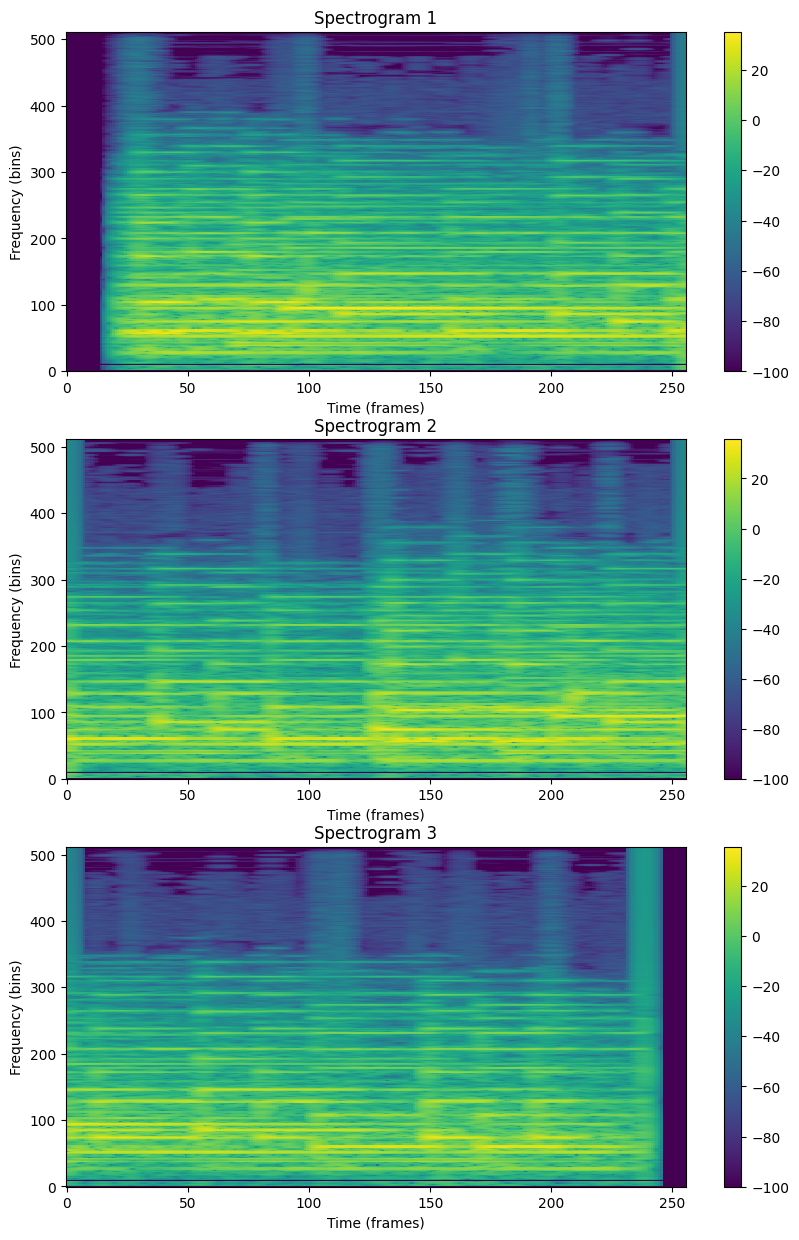

In [17]:
datasets_dir = '/home/samus/programming-projects/datasets/'
songs = [
    datasets_dir + 'in-the-morning-jcole.mp3',
    'datasets/in-the-morning-jcole.mp3',
    'datasets/relaxing-piano-201831.mp3',
]

audio, sr = librosa.load(songs[0], sr=16000)
model = InferenceModel()
inferenced = model(audio)
print(audio.shape)

In [15]:
np.save(datasets_dir + 'torch_ds.npy', audio)

In [16]:
# compare torch_ds.npy and tf_ds.npy to see if they are the same
torch_audio = np.load(datasets_dir + 'torch_ds.npy')
tf_audio = np.load(datasets_dir + 'tf_ds.npy')
print(torch_audio.shape, tf_audio.shape)

# check if the audio is the same
print(np.allclose(torch_audio, tf_audio))

(3781985,) (3781985,)
True
